In [5]:

# Please note that block size = 512B (as per blktrace)



# Blktrace gets its data from the Linux kernel which considers sectors to be 512 bytes long.
# So I think that, regardless of the device physical sector size,
# blktrace displays offsets and sizes in 512-bytes sectors.


# Since default linux block size = 4096, so blktrace works in multiples of 8 blocks at a time (512*8)






In [10]:
import math

def count_blocks(data):
    block_counter_dict = {}
    block_read_counter_dict = {}
    block_write_counter_dict = {}
    
    for row in data.itertuples():
        flag_r = False
        
#         print (type(row.PID))
#         if (isinstance(row.PID, float) and not math.isnan(row.PID)):
        process_id = int(row.PID)

        # Trace event PID will be greater than 2000, ignore others
        if process_id > 2000:
            
            if (row.Start_Block.isdigit()):
                start_block = int(row.Start_Block)
            else:
                continue
                
                
            # Find "R" because Activity can be RWBS (man blkparse)
            if (row.Activity.find("R") >= 0):
                flag_r = True  # else flag = Write

            
            
            if (math.isnan(row.Number_of_Blocks)):
                next_blocks_count = 0
            else:
                next_blocks_count = int(row.Number_of_Blocks)

                
            
            # Incrememnt next blocks counter
            for i in range(0, next_blocks_count):
                if (start_block+i in block_counter_dict):
                    block_counter_dict[start_block+i] += 1
                else:
                    block_counter_dict[start_block+i] = 1
                    
                    
                    
            # Read and Write counters
            for i in range(0, next_blocks_count):
                if (flag_r):
                    if (start_block+i in block_read_counter_dict):
                        block_read_counter_dict[start_block+i] += 1
                    else:
                        block_read_counter_dict[start_block+i] = 1
                else:        # else means write
                    if (start_block+i in block_write_counter_dict):
                        block_write_counter_dict[start_block+i] += 1
                    else:
                        block_write_counter_dict[start_block+i] = 1
                    
    return (block_counter_dict, block_read_counter_dict, block_write_counter_dict)

# Load Trace File  and generate csv

In [20]:
import sys
import csv
import re
import collections
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:

listOfData = []

with open('fileserver_1_cleaned.txt') as f:
    print ("yes")
    for line in f:
#         print (line)
#         new_line = line.split(' ')
        listOfData.append([line])
# print (listOfData[100].split(' '))


print (len(listOfData))

x = listOfData[7197][0]
print(x)
# # y = re.split("[%D] [%2c] [%8s] [%5T.%9t] [%5p] [%2a] [%3d]", x)
# y = x.extract(" ")
# # y = x.split()
# print (y)



list_of_list = []

for i in listOfData:
    strr = i[0]
    split_str = strr.split()
    list_of_list.append(split_str)
    
print(list_of_list[7197])

yes
750981
  8,6    6     4937   120.245877741     0  C   W 1115568896 + 488 [0]

['8,6', '6', '4937', '120.245877741', '0', 'C', 'W', '1115568896', '+', '488', '[0]']


In [4]:
with open('extracted_fileserver_15mins.csv', 'w') as out_file:
    writer = csv.writer(out_file)
#     writer.writerow(('Dev <mjr, mnr>', 'CPU', 'Sequence_Number', 'Timestamp', 'PID', 'Event', 'Activity', 'Start_Block', '+', 'Number_of_Blocks', 'Process'))
    writer.writerows(list_of_list)

# print listOfData

In [2]:
import pandas as pd


# data = pd.read_csv('extracted.csv')

data = pd.read_csv('extracted_fileserver_15mins.csv', names=['Dev <mjr, mnr>', 'CPU', 'Sequence_Number', 'Timestamp', 'PID', 'Event', 'Activity', 'Start_Block', '+', 'Number_of_Blocks', 'Process'])
data[2000:2040]
# data.shape

,"Dev <mjr, mnr>",CPU,Sequence_Number,Timestamp,PID,Event,Activity,Start_Block,+,Number_of_Blocks,Process
2000,"8,6",6,770,109.884189,0,C,W,1110897280,+,208.0,[0]
2001,"8,6",6,771,109.884742,0,C,W,1110897488,+,472.0,[0]
2002,"8,6",6,772,109.885074,0,C,W,1110865664,+,64.0,[0]
2003,"8,6",6,773,109.886944,0,C,W,1110897960,+,1856.0,[0]
2004,"8,6",6,774,109.887391,0,C,W,1110839936,+,16.0,[0]
2005,"8,6",6,775,109.890717,0,C,W,1110899816,+,1960.0,[0]
2006,"8,6",6,776,109.891184,0,C,W,1114897744,+,40.0,[0]
2007,"8,6",6,777,109.891720,0,C,W,1114906112,+,464.0,[0]
2008,"8,6",6,778,109.895584,0,C,W,1110901776,+,1728.0,[0]
2009,"8,6",6,779,109.896400,0,C,W,1114906576,+,384.0,[0]


# Block trace analysis

In [13]:
block_counter_dict, block_read_counter_dict, block_write_counter_dict = count_blocks(data)


print ("Number of blocks accessed", len(block_counter_dict))
print ("Sum of all the block accesses", sum(block_counter_dict.values()))

# print(sum(block_read_counter_dict.values()), sum(block_write_counter_dict.values()))

Number of blocks accessed 3378200
Sum of all the block accesses 87372264
8888 87363376


In [6]:
# print(sorted(block_counter_dict.values(), reverse=True))

In [8]:
import collections

sorted_block_counter_dict = collections.OrderedDict(sorted(block_counter_dict.items()))


In [15]:
import collections

sorted_block_read_counter_dict = collections.OrderedDict(sorted(block_read_counter_dict.items()))
sorted_block_write_counter_dict = collections.OrderedDict(sorted(block_write_counter_dict.items()))

In [9]:

sorted_df = pd.DataFrame.from_dict(sorted_block_counter_dict, orient='index')

print(sorted_df)

             0
833517568   11
833517569   11
833517570   11
833517571   11
833517572   11
...         ..
1873987619   1
1873987620   1
1873987621   1
1873987622   1
1873987623   1

[3378200 rows x 1 columns]


In [16]:
sorted_read_df = pd.DataFrame.from_dict(sorted_block_read_counter_dict, orient='index')
sorted_write_df = pd.DataFrame.from_dict(sorted_block_write_counter_dict, orient='index')


### All access plots

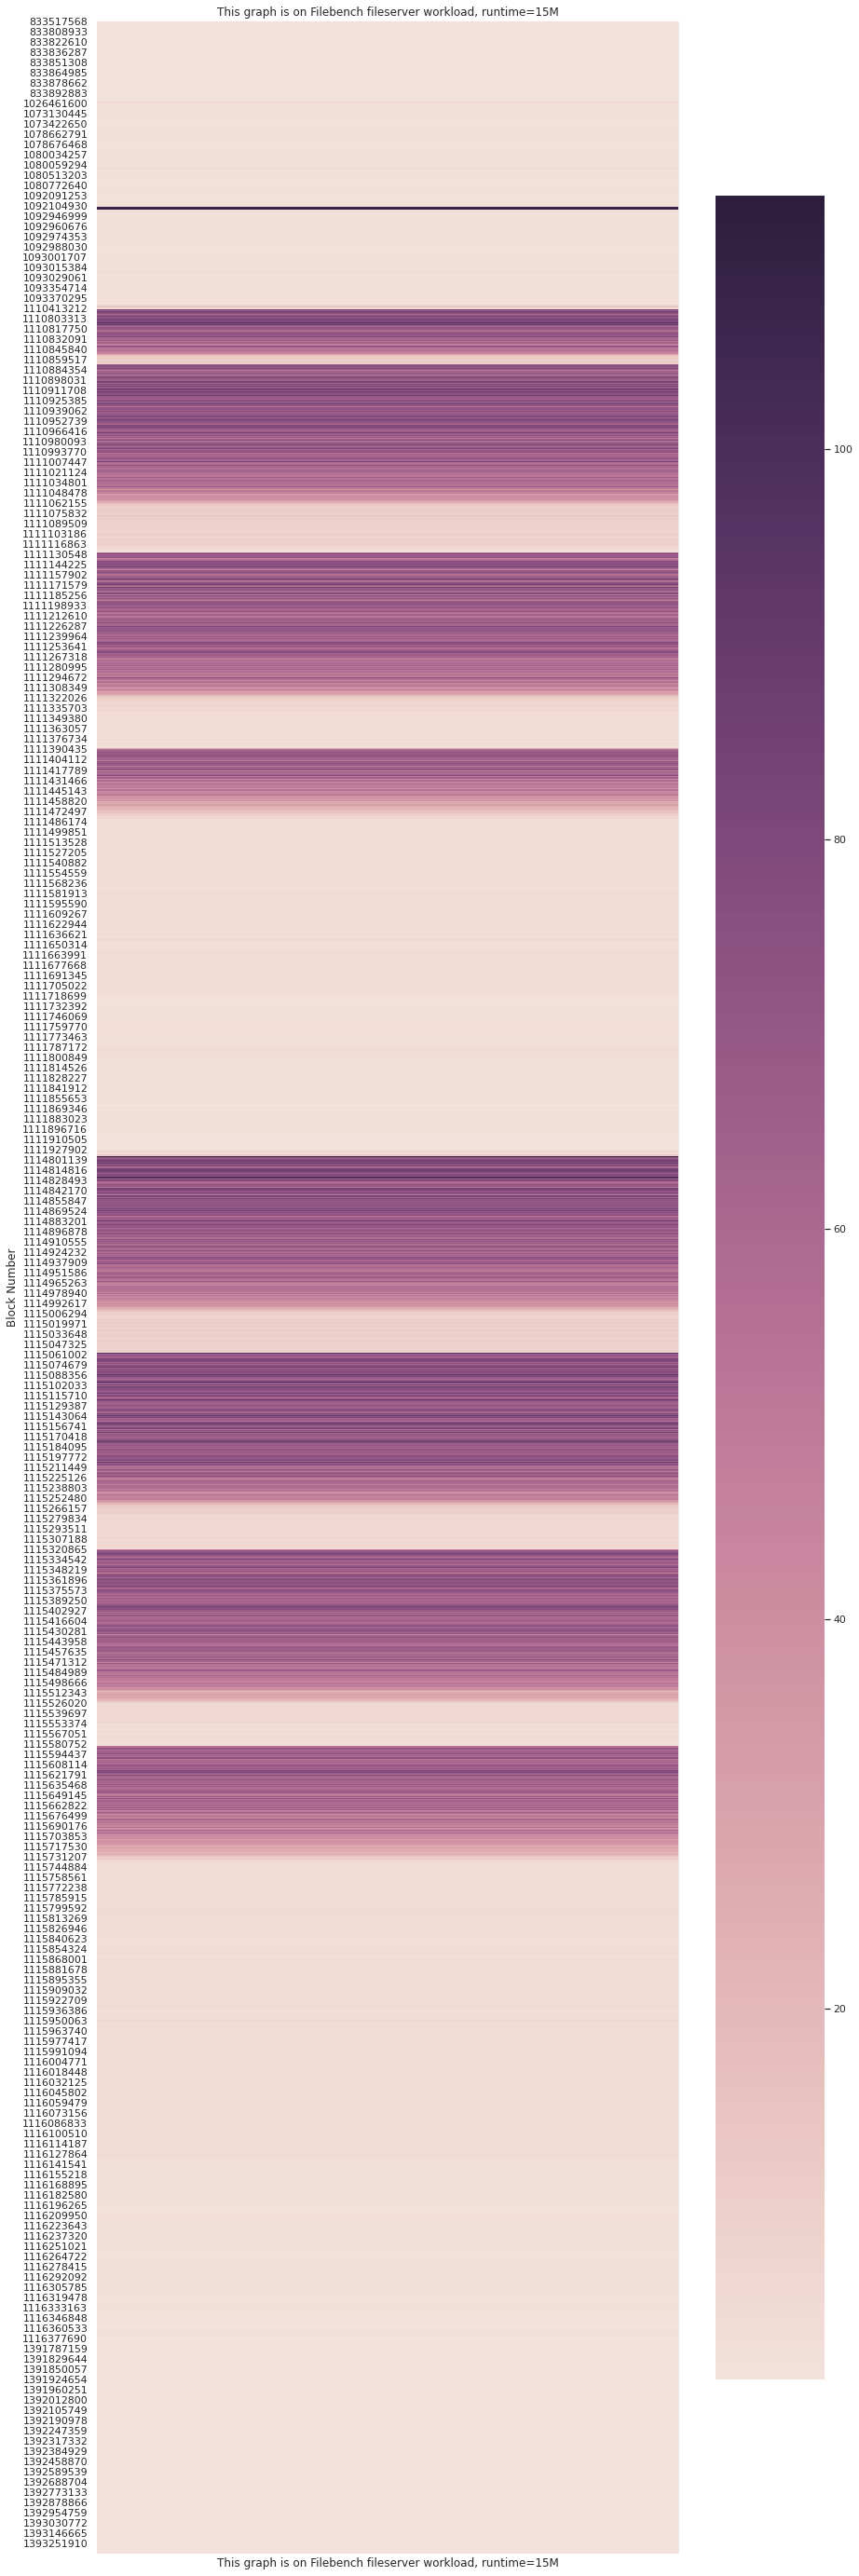

In [10]:
sns.set(rc={'figure.figsize':(14,50)})

cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)

heatmap = sns.heatmap(sorted_df, cmap=cmap_i, xticklabels=False)
plt.xlabel('This graph is on Filebench fileserver workload, runtime=15M')
plt.ylabel('Block Number')

plt.title('This graph is on Filebench fileserver workload, runtime=15M')
plt.show()

### Plot of number of reads and writes wrt each block

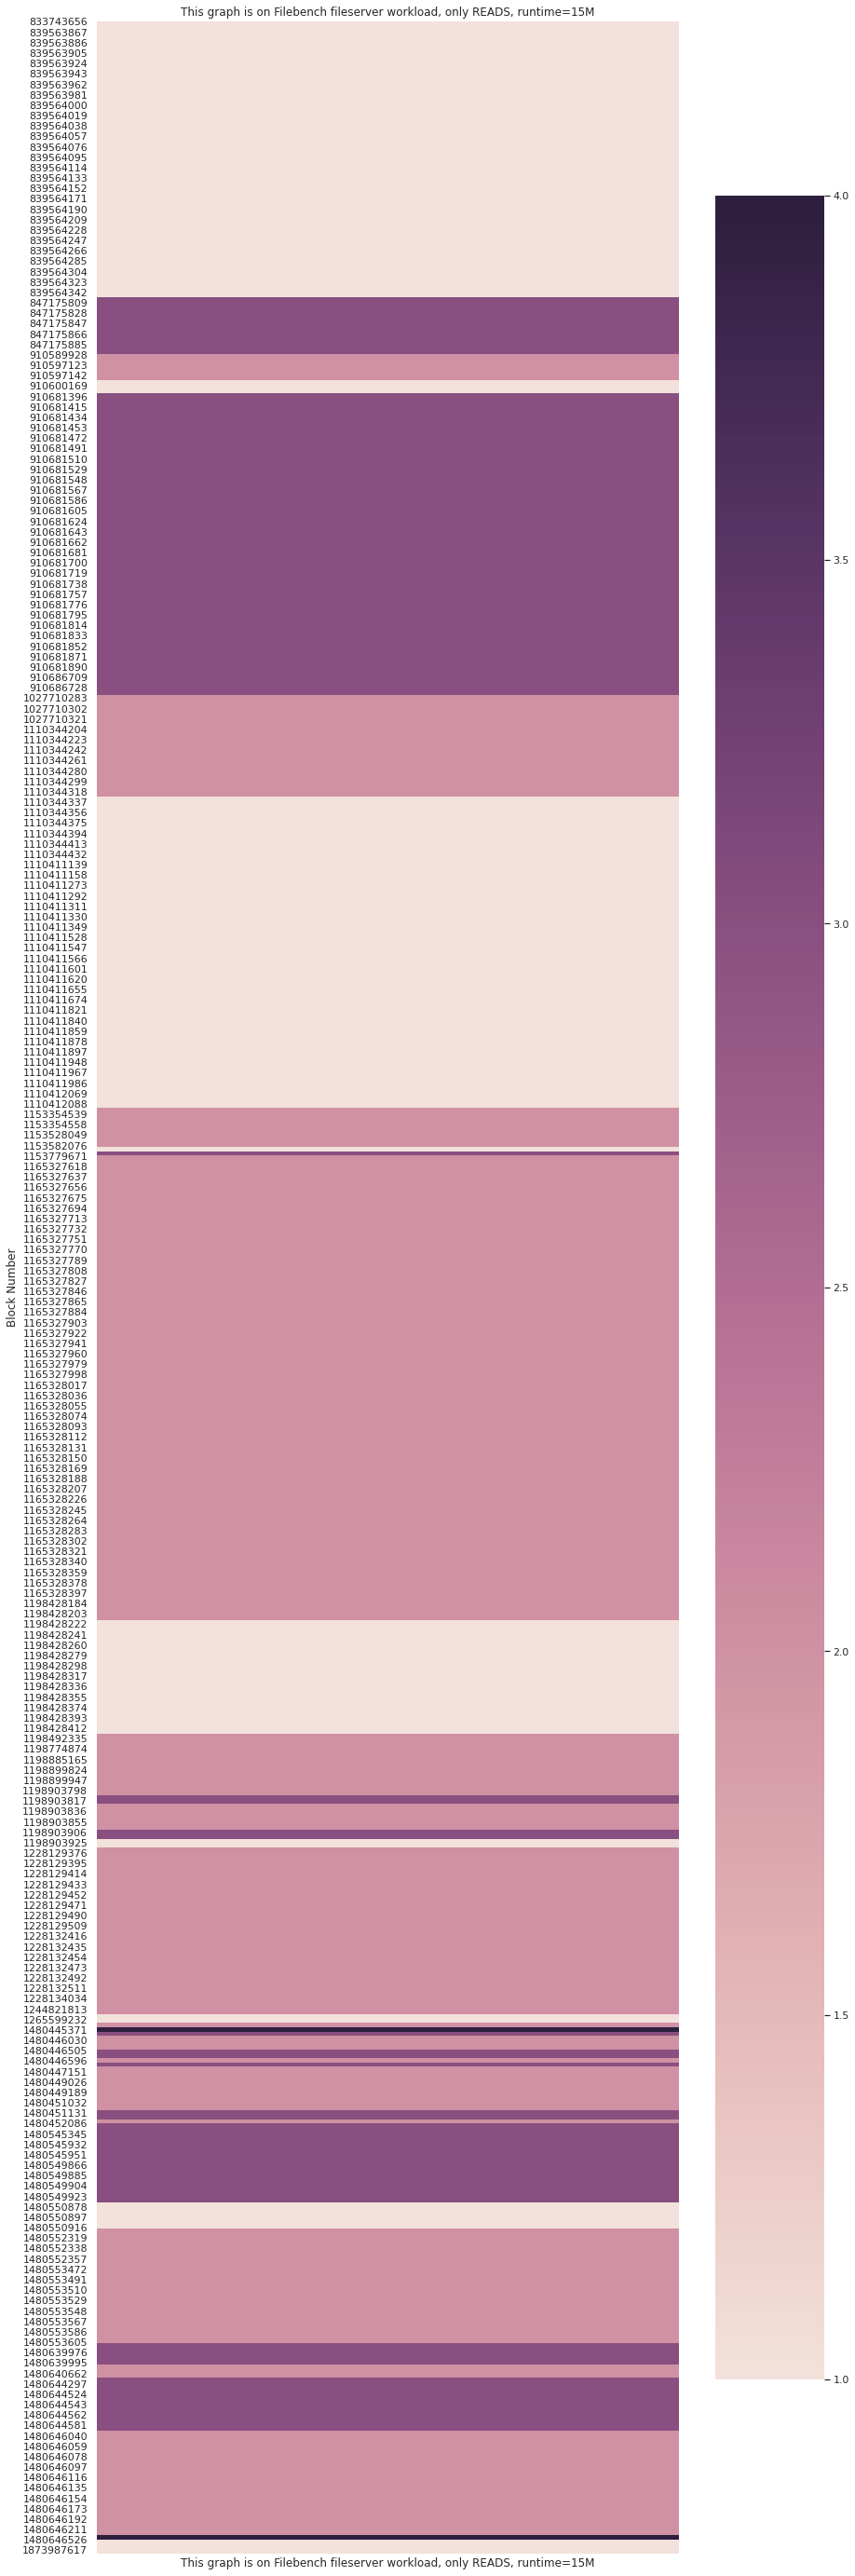

In [21]:
sns.set(rc={'figure.figsize':(14,50)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(sorted_read_df, cmap=cmap_i, xticklabels=False)
plt.xlabel('This graph is on Filebench fileserver workload, only READS, runtime=15M')
plt.ylabel('Block Number')

plt.title('This graph is on Filebench fileserver workload, only READS, runtime=15M')
plt.show()


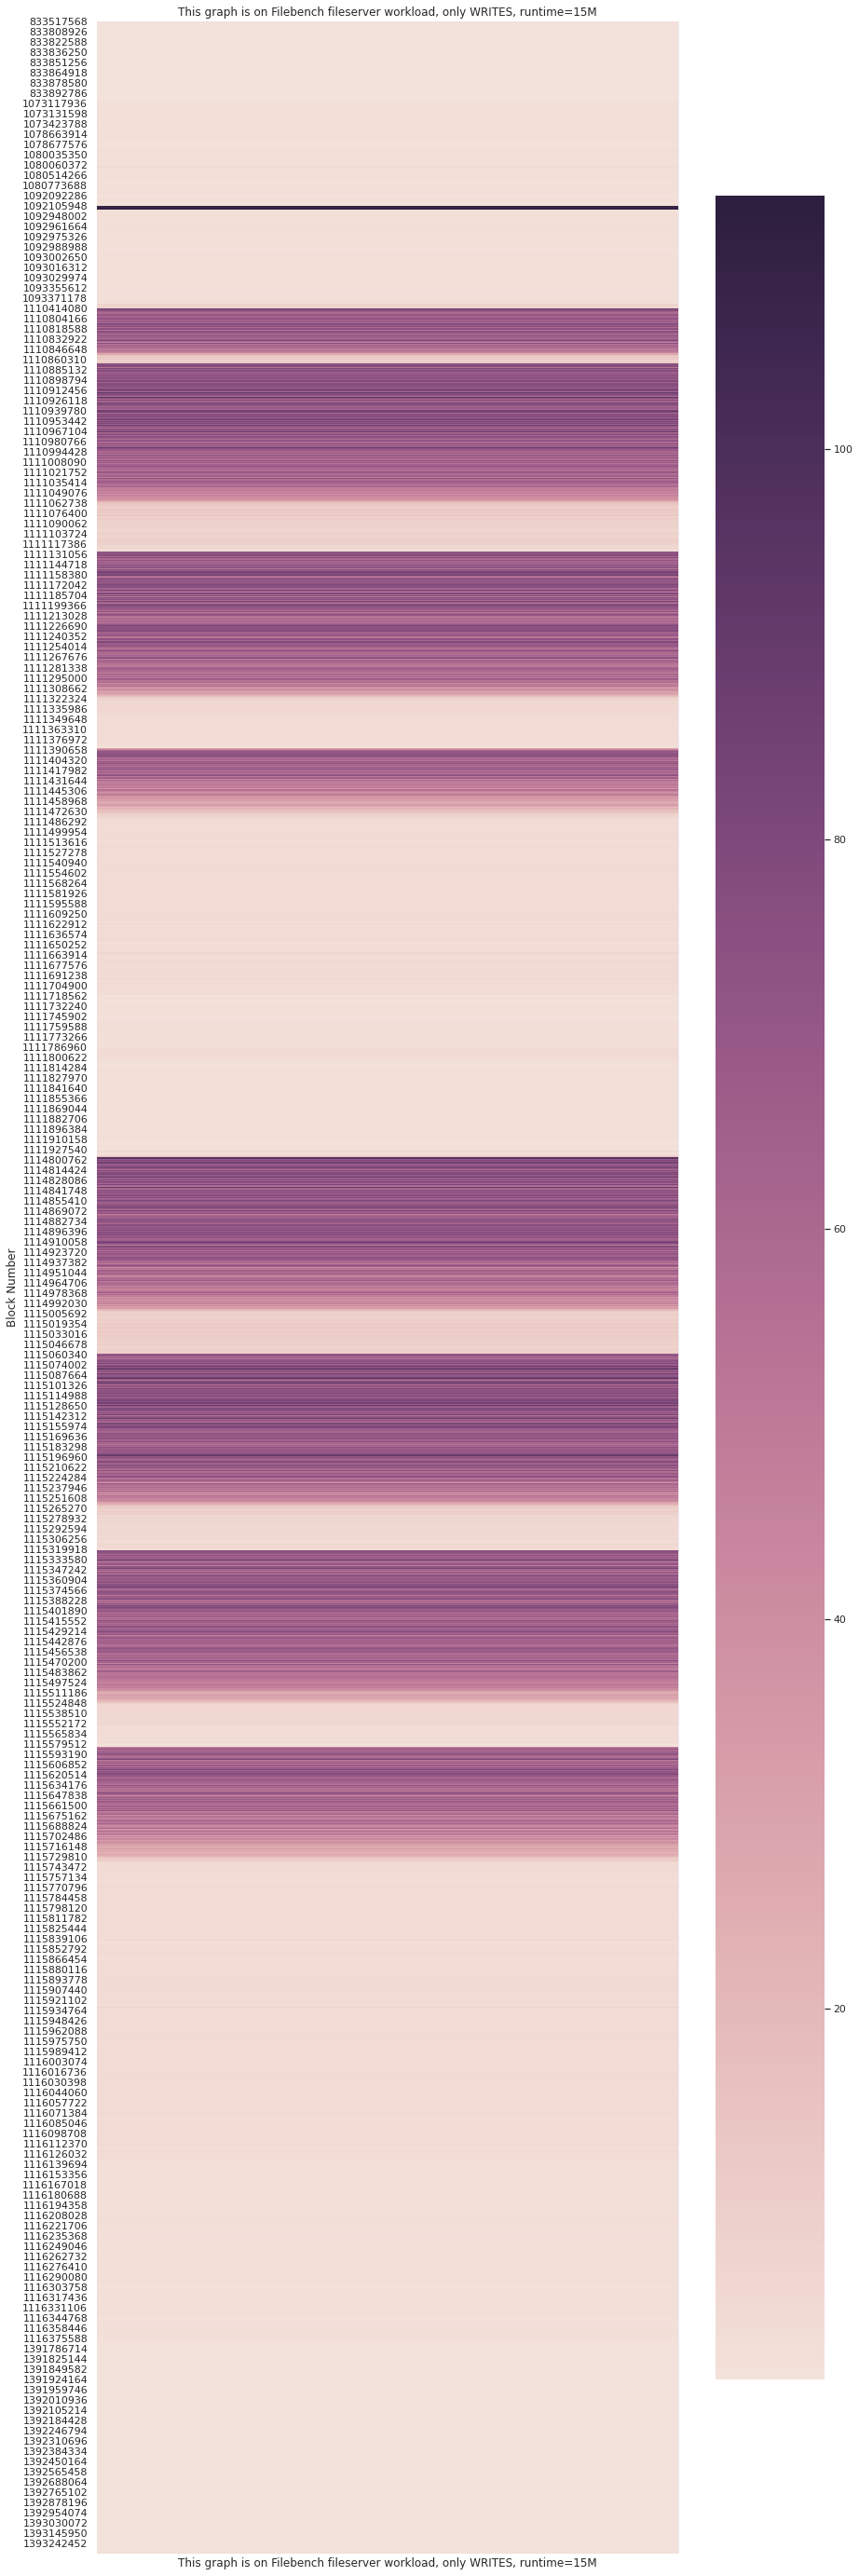

In [22]:
sns.set(rc={'figure.figsize':(14,50)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(sorted_write_df, cmap=cmap_i, xticklabels=False)
plt.xlabel('This graph is on Filebench fileserver workload, only WRITES, runtime=15M')
plt.ylabel('Block Number')

plt.title('This graph is on Filebench fileserver workload, only WRITES, runtime=15M')
plt.show()

### Distribution Fucntions

In [7]:
block_range_2000_plus = 0
block_range_1000_2000 = 0
block_range_500_1000 = 0
block_range_100_500 = 0
block_range_50_100 = 0
block_range_10_50 = 0
block_range_2_10 = 0
block_range_1 = 0
block_range_0 = 0




io_range_2000_plus = 0
io_range_1000_2000 = 0
io_range_500_1000 = 0
io_range_100_500 = 0
io_range_50_100 = 0
io_range_10_50 = 0
io_range_2_10 = 0
io_range_1 = 0





list_block_access_desc = sorted(block_counter_dict.values(), reverse=True)

for i in list_block_access_desc:
    if i >= 2000:
        block_range_2000_plus += 1
        io_range_2000_plus += i
        
    elif i >= 1000 and i < 2000:
        block_range_1000_2000 += 1
        io_range_1000_2000 += i
        
    elif i >= 500 and i < 1000:
        block_range_500_1000 += 1
        io_range_500_1000 += i
        
    elif i >= 100 and i < 500:
        block_range_100_500 += 1
        io_range_100_500 += i
        
    elif i >= 50 and i < 100:
        block_range_50_100 += 1
        io_range_50_100 += i
        
    elif i >=10 and i <= 50:
        block_range_10_50 += 1
        io_range_10_50 += i
        
    elif i >=2 and i <= 10:
        block_range_2_10 += 1
        io_range_2_10 += i
        
    elif i == 1:
        block_range_1 += 1
        io_range_1 += i
        
total_number_of_blocks = max(block_counter_dict)
block_range_0 = (total_number_of_blocks - (len(block_counter_dict)))


print("block_range_2000_plus", block_range_2000_plus)
print("block_range_1000_2000", block_range_1000_2000)
print("block_range_500_1000", block_range_500_1000)
print("block_range_100_500", block_range_100_500)
print("block_range_50_100", block_range_50_100)
print("block_range_10_50", block_range_10_50)
print("block_range_2_10", block_range_2_10)
print("block_range_1", block_range_1)
print("block_range_0", block_range_0)

number_of_blocks_total_accessed = block_range_2000_plus + block_range_1000_2000 + block_range_500_1000 + block_range_100_500 + block_range_50_100 + block_range_10_50 + block_range_2_10 + block_range_1
print("sum of all accessed blocks = ", number_of_blocks_total_accessed)



print("\n\n\n")


print("io_range_2000_plus", io_range_2000_plus)
print("io_range_1000_2000", io_range_1000_2000)
print("io_range_500_1000", io_range_500_1000)
print("io_range_100_500", io_range_100_500)
print("io_range_50_100", io_range_50_100)
print("io_range_10_50", io_range_10_50)
print("io_range_2_10", io_range_2_10)
print("io_range_1", io_range_1)

total_IOs_block = io_range_2000_plus + io_range_1000_2000 + io_range_500_1000 + io_range_100_500 + io_range_50_100 + io_range_10_50 + io_range_2_10 + io_range_1
print("sum of all IOs = ", total_IOs_block)

block_range_2000_plus 0
block_range_1000_2000 0
block_range_500_1000 0
block_range_100_500 4616
block_range_50_100 1071488
block_range_10_50 298440
block_range_2_10 1528272
block_range_1 475384
block_range_0 1870609423
sum of all accessed blocks =  3378200




io_range_2000_plus 0
io_range_1000_2000 0
io_range_500_1000 0
io_range_100_500 499688
io_range_50_100 72328784
io_range_10_50 8848912
io_range_2_10 5219496
io_range_1 475384
sum of all IOs =  87372264


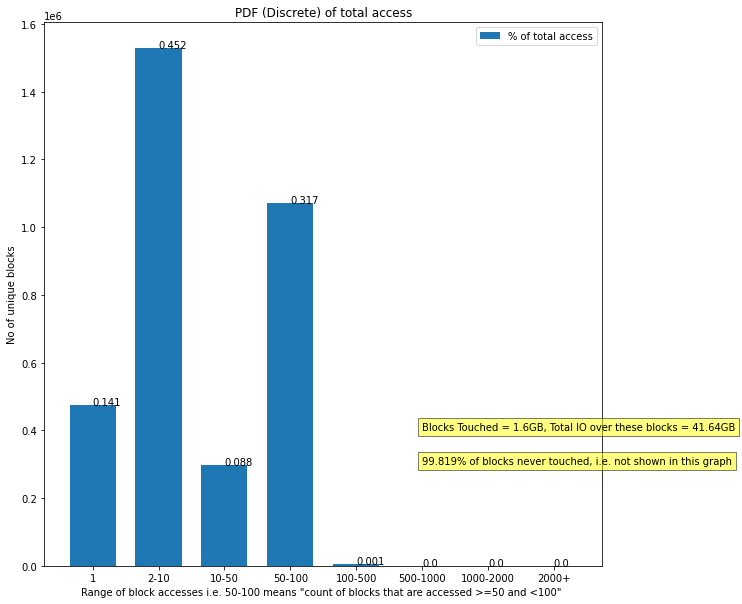

In [8]:
import matplotlib.pyplot as pyplot

pyplot.figure(figsize=(10,10))

x_axis = ["1", "2-10", "10-50", "50-100", "100-500", "500-1000", "1000-2000", "2000+"]

y_axis = [block_range_1, block_range_2_10, block_range_10_50,
          block_range_50_100, block_range_100_500, block_range_500_1000,
          block_range_1000_2000, block_range_2000_plus]

pyplot.bar(x_axis, y_axis, width=0.7, label='% of total access')
# pyplot.bar(x_h, host_read_latency, width=0.7, label='Oasis')
# pyplot.xticks([])
pyplot.legend(loc='upper right')
pyplot.title("PDF (Discrete) of total access")
pyplot.ylabel('No of unique blocks')
pyplot.xlabel('Range of block accesses i.e. 50-100 means "count of blocks that are accessed >=50 and <100" ')
pyplot.text(5, 300000, "99.819% of blocks never touched, i.e. not shown in this graph", bbox=dict(facecolor='yellow', alpha=0.5))
pyplot.text(5, 400000, "Blocks Touched = 1.6GB, Total IO over these blocks = 41.64GB", bbox=dict(facecolor='yellow', alpha=0.5))


for i in range(len(x_axis)):
    pyplot.annotate(str(round(y_axis[i]/number_of_blocks_total_accessed, 3)), xy=(x_axis[i], y_axis[i]))



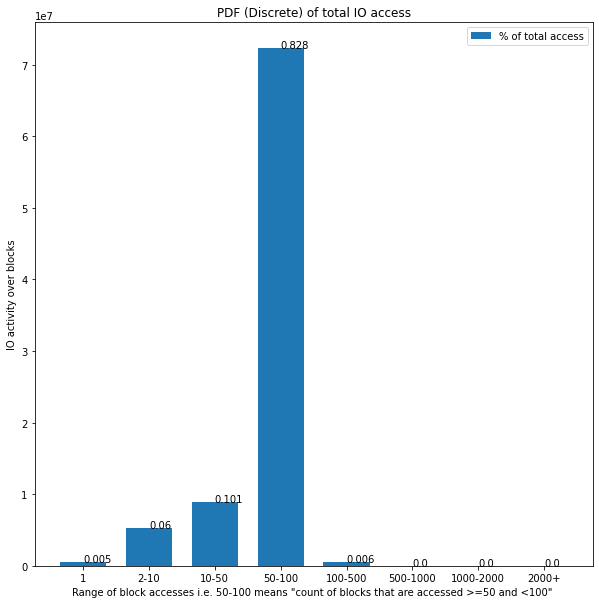

In [11]:
import matplotlib.pyplot as pyplot

pyplot.figure(figsize=(10,10))

x_axis = ["1", "2-10", "10-50", "50-100", "100-500", "500-1000", "1000-2000", "2000+"]

y_axis = [io_range_1, io_range_2_10, io_range_10_50,
          io_range_50_100, io_range_100_500, io_range_500_1000,
          io_range_1000_2000, io_range_2000_plus]

pyplot.bar(x_axis, y_axis, width=0.7, label='% of total access')
# pyplot.bar(x_h, host_read_latency, width=0.7, label='Oasis')
# pyplot.xticks([])
pyplot.legend(loc='upper right')
pyplot.title("PDF (Discrete) of total IO access")
pyplot.ylabel('IO activity over blocks')
pyplot.xlabel('Range of block accesses i.e. 50-100 means "count of blocks that are accessed >=50 and <100" ')
# pyplot.text(5, 150000, "99.982% of blocks never touched, i.e. not shown in this graph", bbox=dict(facecolor='yellow', alpha=0.5))

for i in range(len(x_axis)):
    pyplot.annotate(str(round(y_axis[i]/total_IOs_block, 3)), xy=(x_axis[i], y_axis[i]))

